In [1]:
# Standard library
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.io as pio
from IPython.display import Image

# Custom modules
from empirical_null import empirical_null_provider_failures
from hierarchical_bayes import fit_hierarchical_logistic_model, plot_bayesian_coefficients
from survival_analysis import bayesian_cox_model, plot_bayesian_cox_effects
from utils import calculate_vif, generate_later_timestamp_column, plot_outcome_by_physician_hra

import warnings
warnings.filterwarnings('ignore')


# Clover Health Technical 
### Overall Goal : using data provided qualify/quanitify doctor's efficacy wrt a certain medical condition to provide data driven guidance on whether or not an insureance company considering adding physicians should have concerns about any/all individual physicians 

1. ie. If you were to only consider the provider's effectiveness with regard to this particular
treatment, would you recommend reaching out to any of these doctors in particular? If so, which
ones, and why?

### Strategy : 
- Exploratory data analysis, understand if there is any bias or trends that may be affecting the data ie; do ay physicians only treat certain types of patients in terms of covariates? Is there a time bias to patient outcomes? Are any other covariates highly associated with outcome? How many patients does each physician see? ect. 
- Evaluate effect of physician on outcome 
    - Assumptions : 
        - nan in outcome is a positive results (lack of health failure)
        - Size of data provided is equivalent to size of population (solutions are not optimized for scale)
    - Method 1 : 
        - Use a heirarchical bayesian logistic regression to determine the probability that any given provider has an increased likelihood of a failure while accounting for covariates
    - Method 2 :  
        - Using a covariate adjusted empirical null to determine whether any providers have significantly different than expected failure rates while accounting for covariates



#### Exploratory Data Analysis 

In [2]:
data = pd.read_csv("data/Product_Data.csv")

In [3]:
# number of providers and number of patients 
print(f"number of unique provider ids : {data.servicing_provider_id.nunique()}")
print(f"number of unique patient ids : {data.member_id.nunique()}")

# we also have servicing name, how does this map to id 
print(data[["servicing_provider_id", "servicing_provider_name"]].drop_duplicates().value_counts().value_counts())
# looks like there is a one to one mapping for each servicing provider name and servicing provider id 

# lets understand patient results 

# are there any missing values 
print(data.outcome.isna().value_counts())
# yes between 1/2-1/3 are missing outcomes 

# what are the nonmissing outcomes 
print(data.outcome.value_counts())
print(f"outcomes are {data.outcome.unique()}")
# so we come to our first assumption; Na's in outcome are successes (only alternative is failure)
# in which case we can either take a comparartive approach or a survival approach if we interpret this as no followup

# is there only 2 outcome per patient? 
print(data.groupby("member_id").outcome.nunique().value_counts() )
print(f"number of patients with multiple outcomes: {data.groupby('member_id').outcome.nunique().value_counts().get(2, 0)}")

# how many visits per patient
print(data.groupby("member_id").event_id.nunique().value_counts())
print(f"number of patients with multiple visits: {data.groupby('member_id').event_id.nunique().value_counts().get(2, 0)}")
# okay so we have a single outcome per patient, and a single visit per patient

print(data.groupby("member_id").servicing_provider_id.nunique().value_counts())
print(f"number of patients with multiple providers: {data.groupby('member_id').servicing_provider_id.nunique().value_counts().get(2, 0)}")
# all patients only see 1 provider 

# lets just check for NA's 
data.isna().value_counts()
# outcome is the only column with NA's

number of unique provider ids : 96
number of unique patient ids : 4247
count
1    96
Name: count, dtype: int64
outcome
False    2413
True     1834
Name: count, dtype: int64
outcome
failure    2413
Name: count, dtype: int64
outcomes are ['failure' nan]
outcome
1    2413
0    1834
Name: count, dtype: int64
number of patients with multiple outcomes: 0
event_id
1    4247
Name: count, dtype: int64
number of patients with multiple visits: 0
servicing_provider_id
1    4247
Name: count, dtype: int64
number of patients with multiple providers: 0


event_id  servicing_provider_id  servicing_provider_name  treatment_date  member_id  member_age  member_sex  health_risk_assesment  outcome
False     False                  False                    False           False      False       False       False                  False      2413
                                                                                                                                    True       1834
Name: count, dtype: int64

In [4]:
# what about how many patients each provider sees 
patientsxprovider = data.groupby("servicing_provider_id").member_id.nunique()
print(f"providers have on average {patientsxprovider.mean():.2f} patients, with a std of {patientsxprovider.std():.2f}")
fig = px.histogram(patientsxprovider, title="Patients per Provider")
fig.add_vline(x=patientsxprovider.mean(), line_color="red", line_dash="dash", annotation_text="Mean", annotation_position="top left")
fig.show()


providers have on average 44.24 patients, with a std of 6.36


In [5]:
# what about how many patients each provider sees 
outcomesxprovider = data.groupby("servicing_provider_id").outcome.count()
# lets look at this with respect to proportion of patients that fail
outcomes_prop_xprovider = outcomesxprovider.values / patientsxprovider.values
px.histogram(outcomes_prop_xprovider)
# proportion of patients that fail is normally distributed, maybe slightly skewed left

In [6]:
# health risk assessment by provider 
hrasxprovider = data.groupby("servicing_provider_id").health_risk_assesment.nunique()
print(hrasxprovider.value_counts())
print("7 providers see patients with only 1 health risk assessment score, most providers see patients with 1 several health risk assessment scores")

health_risk_assesment
9     62
10    19
8     14
7      1
Name: count, dtype: int64
7 providers see patients with only 1 health risk assessment score, most providers see patients with 1 several health risk assessment scores


In [7]:
# ASSUMPTION 1 : NA in outcome is a success 
data_outcome_compare = data.copy()
data_outcome_compare["outcome"] = data.outcome.fillna("pass")

In [8]:
# plot by time 
data_by_time = data.groupby(["treatment_date", "outcome"]).member_id.nunique().reset_index()
data_by_time["treatment_date"] = pd.to_datetime(data_by_time["treatment_date"])

fig = px.line(data_by_time.sort_values("treatment_date"), x="treatment_date", y="member_id", color="outcome", markers=True)
fig.show()
# doesnt appear to be a strong trend over time

In [9]:
# lets check member age too 
data_outcome_compare["member_age"].isna().value_counts()
# no missing values
data_outcome_compare_count = data_outcome_compare.groupby(["member_age", "health_risk_assesment", "outcome"]).member_id.count().reset_index()
fig = px.scatter(x="health_risk_assesment", y="member_age", size="member_id",  data_frame=data_outcome_compare_count, color="outcome")
age_risk_corr = data_outcome_compare[["health_risk_assesment", "member_age"]].corr().iloc[0,1]
fig.add_annotation(
    xref="paper", yref="paper", x=0.05, y=0.95,
    text=f"Correlation: {age_risk_corr:.2f}",
    showarrow=False,
    font=dict(size=14, color="black"),
    bgcolor="white"
)
fig.show()
# doesnt appear to be a strong relationship between age and outcome, but we can see that the health risk assessment at the extremes relates to age

In [10]:
cat_plot = data_outcome_compare[["member_sex", "health_risk_assesment", "outcome"]].value_counts().reset_index()
cat_plot["member_sex"] = cat_plot["member_sex"].replace({0:"F", 1:"M"})
px.bar(cat_plot, x="health_risk_assesment", y="count", color="outcome", facet_col="member_sex", barmode="group")
# Females do seem to have more positive outcomes at higher health risk assesment scores

Looks like there is a moderate global correlation between age and health risk assesment and we know form our information that age and sex are incorporated into this measures. Since we plan to use bayesian methods we should probably want to assess for colinearity 

In [11]:
vif_df = calculate_vif(data_outcome_compare, ["member_age", "health_risk_assesment", "member_sex"])
px.bar(vif_df, x="feature", y="VIF", title="Variance Inflation Factor (VIF) for Features").show()

high_vif_features = vif_df.query("VIF > 5")
if not high_vif_features.empty:
    print(f"Warning: The following features have VIF > 5 and indicate multicollinearity: {list(high_vif_features['feature'])}")
    print("One of these will be dropped for downstream analysis to reduce collinearity.")

One of these will be dropped for downstream analysis to reduce collinearity.


#### Method 1 : Hierarchical Bayesian Logistic Regression
 - Using a heirarchical bayesian logistic regression we can calculate an effect for every provider against the global mean separate from the effect of the covariates. 
 - This approach is relatively scalable, assesses all providers in one model, and quantifies the effect of provider relative to other covariates 

In [12]:
fit_data, provider_encoder = fit_hierarchical_logistic_model(
    df=data_outcome_compare,
    covariates=["member_sex","health_risk_assesment"],
    target_col="outcome",
    provider_col="servicing_provider_id"
)

[1 1 0 ... 1 1 1]


Initializing NUTS using jitter+adapt_diag...
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_provider, provider_offset, intercept, betas]
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [sigma_provider, provider_offset, intercept, betas]
Multiprocess sampling (4 chains in 4 jobs)
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_provider, provider_offset, intercept, betas]
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [sigma_provider, provider_offset, intercept, betas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


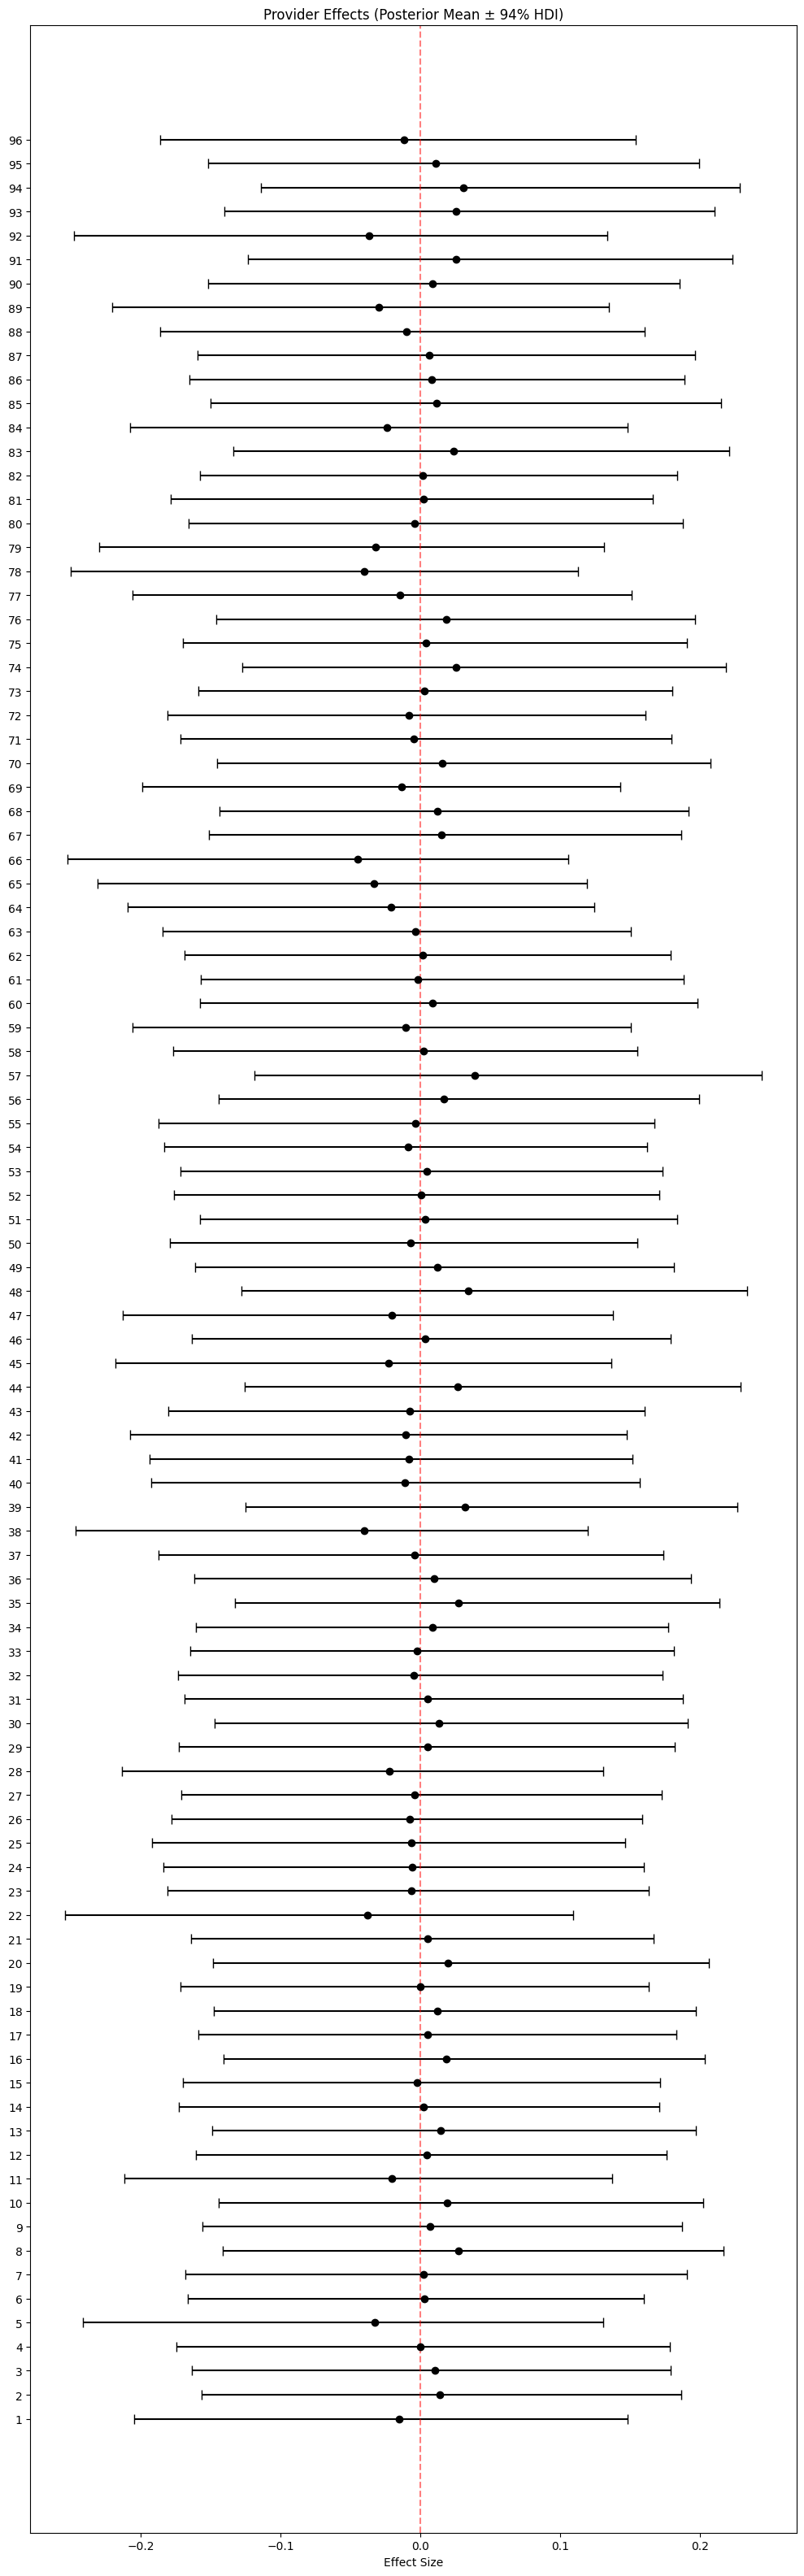

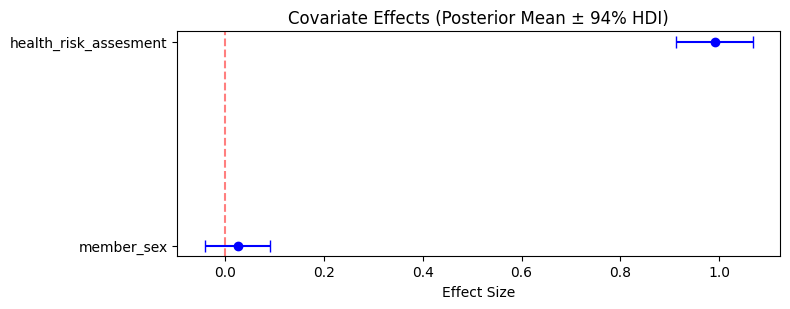

In [13]:
plot_bayesian_coefficients(fit_data, provider_encoder, ["member_sex", "health_risk_assesment"])

#### Results and interpretation of Hierarchical bayes : 
- Looking at the results from our hierarchical logistic regression we can see that all the HDI (highest density interval) for all providers covers 0 and no provider has an average effect greater than 0.1.
- while certain providers do have an average effect greater or above 0, the width of the  intervals suggests these is no real effect of any given provider on the probability of the outcome (pass or failure)
- By comparison the health_risk_assesment effect has a beta of ~ 1 indicating a large effect on outcome. 
- Member sex has a smaller affect, similar in magnitude to the provider effects.

#### Method 2 : Covariate Adjusted Empirical Null 
 - For each provider train a logistic regression model on other providers patients predicting outcome by covariate alone. Use this model to determine a probability of failure for each patient of this provider based on covariates alone. Use these probabilities to inform a binomial distribution for n permutations to construct a distribution of expected failure proportions for each physician given their patient covariates. Compare the physicians actually failure rate to the constructed null to determine if their failure rate is significantly deviated from the expected. 
 - Essentially this analysis seeks to answer the question; Is the number of failures for a given physicians significantly different from what would be expected given their patients covariates. 
 - This approach is computationally expensive as it employs permutation per provider,  it also quantifies and qualifies the effect of a physician has on their patients given their patients covariates. 

In [14]:
empirical_null_covariate_test=empirical_null_provider_failures(data_outcome_compare, "outcome", "servicing_provider_id", ["health_risk_assesment", "member_sex"], n_simulations=1000, random_state=42)

Simulating nulls by provider:   0%|          | 0/96 [00:00<?, ?it/s]

Simulating nulls by provider: 100%|██████████| 96/96 [00:00<00:00, 101.42it/s]


In [15]:
# addressing issues in log reg above, could be because all females with a health risk assesment of 1 all pass 
# and there are no men with a health risk assessment of 1
data_outcome_compare.groupby(["member_sex", "health_risk_assesment", "outcome"]).member_id.count().sort_index()

member_sex  health_risk_assesment  outcome
0           1                      pass       133
            2                      failure     31
                                   pass       258
            3                      failure    131
                                   pass       191
            4                      failure    180
                                   pass       131
            5                      failure    168
                                   pass        91
            6                      failure    206
                                   pass        95
            7                      failure    201
                                   pass        72
            8                      failure    145
                                   pass        42
            9                      failure     50
                                   pass        13
1           2                      failure     14
                                   pass       127
       

In [16]:
fig = px.scatter(empirical_null_covariate_test, 
    x="observed_failure_rate", 
    y="expected_mean", 
    color="p_value", 
    title="Observed vs Expected Failure Rate by Provider",
    labels={"observed_failure_rate": "Observed Failure Rate", "p_value": "P-Value"}
)

# Add identity line (y = x)
min_val = min(empirical_null_covariate_test["observed_failure_rate"].min(), empirical_null_covariate_test["expected_mean"].min())
max_val = max(empirical_null_covariate_test["observed_failure_rate"].max(), empirical_null_covariate_test["expected_mean"].max())
fig.add_shape(type="line", x0=min_val, y0=min_val, x1=max_val, y1=max_val, line=dict(color="black", dash="dash"))
fig.update_layout(height=500, width=500)
fig.show()

In [17]:
styled_df = empirical_null_covariate_test.query("p_value < 0.05").sort_values("observed_failure_rate", ascending=False)

# Highlight rows based on observed vs expected failure rate
def highlight_row(row):
    color = 'background-color: red' if row['observed_failure_rate'] > row['expected_mean'] else 'background-color: green'
    return [color] * len(row)
empirical_null_styled_df = styled_df.style.apply(highlight_row, axis=1)

bad_providers = empirical_null_covariate_test.query("observed_failure_rate > expected_mean & p_value < 0.05").index.tolist()
print(f"Providers with observed failure rate greater than expected mean: {bad_providers}")
empirical_null_styled_df

Providers with observed failure rate greater than expected mean: [47, 56]


,provider,observed_failure_rate,expected_mean,lower_95_CI,upper_95_CI,p_value
56,57,0.723404,0.591021,0.468085,0.723404,0.029970
47,48,0.704545,0.584295,0.454545,0.704545,0.045954
91,92,0.463415,0.599537,0.463415,0.731707,0.029970
21,22,0.431818,0.568682,0.431818,0.704545,0.033966
77,78,0.431818,0.584182,0.453977,0.727273,0.025974
65,66,0.377778,0.542222,0.422222,0.666667,0.009990
64,65,0.372093,0.500814,0.372093,0.627907,0.046953


#### Results and interpretation of Empirical Null Analysis : 
- Most providers who deviate significantly from the expected failure rate actually have reduced failure rates, suggesting these providers are performing better than expected given their patients' gender and health risk assesment
- This makes sense in the context of our previous model in which we determined no provider had a large effect on probability of failing outcome especially when compared to health risk assesment 

## Recommendation on reaching out to providers : 
- Given the results of both the heirarchical model and the empirical null comparison I would say there is no data at the moment to suggest most of these providers have reduced clinical efficacy. The two prospects the company may want to consider reaching out to would be provider 57 and 48 who performed significantly worse than expected compared to the covariate adjusted null. 
- Visually below we can see that the failure rate increases relatively consistently with health_risk_assesment compared to provider

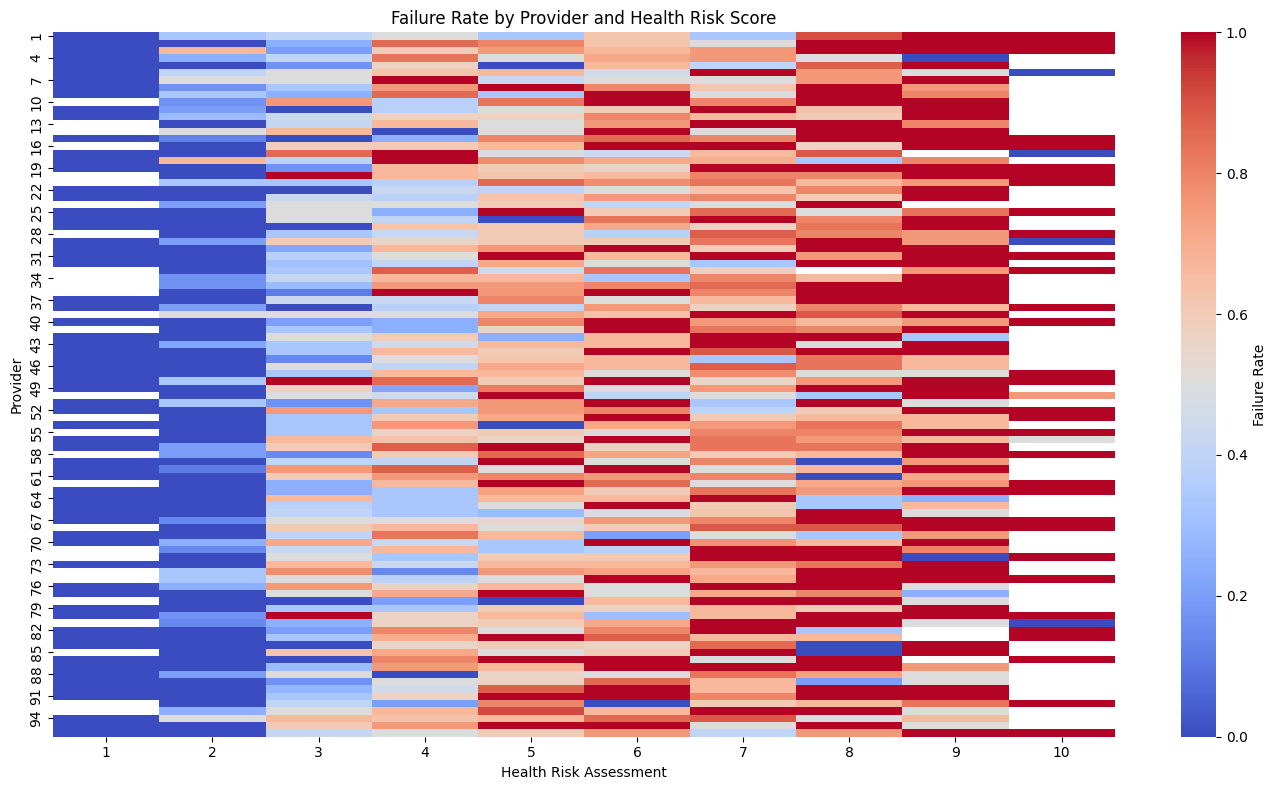

In [18]:
plot_outcome_by_physician_hra(data_outcome_compare)

# What data could we use to improve our recommendations? How would that chance our analysis? 
2. What other data would be helpful in understanding which doctors to reach out to? What other
data would help you evaluate the overall clinical effectiveness of the doctor? How would you use
this data?

#### Other data we would want access to 
 - Zip code 
    - SDOH have been found to be very impactful on health outcomes, Zip code can be mapped to an ADI which would give insight into the socioeconomic status of different patients 
- Treatment location
    - where are individuals recieving these treatments? Where are these physicians practicing? If care begins in an emergent situation rather than through a proactive or preventative visit that may also give some insight into the acuity of the conditions beyond their general health assesment 
- Time/Date of Event or Last Followup 
    - In the analyses above we made the assumption that individuals with no failure were healthy despite these values being NA in the original data cut. There is a chance these individuals just havent experienced the event yet. If we knew the dates of the events and the time since the last follow for individuals we dont have event data for we can investigate whether or not provider has an effect on the time to event, especially of interest if this is a chronic condition. 
- Disease duration
    - If certain physicians focus on certain disease stages there might be a bias in the data (ie. If patients are more progressed in their disease they may be more likely to have a failure so if a physcians exclusively sees more progressed patients their failure rates may be inflated)
- Medications/Therapeutics 
    - We have no insight into how the physicians are managing this disease condition; it might be that patients are electing for different treatments which is affecting their outcomes. 

#### Ex. of advatageous data : Synthesizing Follow up/Event times

- Synthesizing time to event and followup timestampts to explore how this information might change our analysis if we had access to it

In [19]:
data_time_synth = generate_later_timestamp_column(data, "treatment_date", new_col='followup_date', min_days=30, max_days=360, seed=None)

In [20]:
coxmodel, coxdata, provider_names = bayesian_cox_model(data_time_synth, "treatment_date","followup_date", "outcome", "servicing_provider_id", covariates=['member_sex', 'health_risk_assesment'])

Initializing NUTS using jitter+adapt_diag...
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:init_nuts()- Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:sample()- Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_h0, beta, sigma_provider, provider_offset]
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_print_step_hierarchy()- NUTS: [log_h0, beta, sigma_provider, provider_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
INFO	Task(Task-3) pymc.sampling.mcmc:mcmc.py:_sample_return()- Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


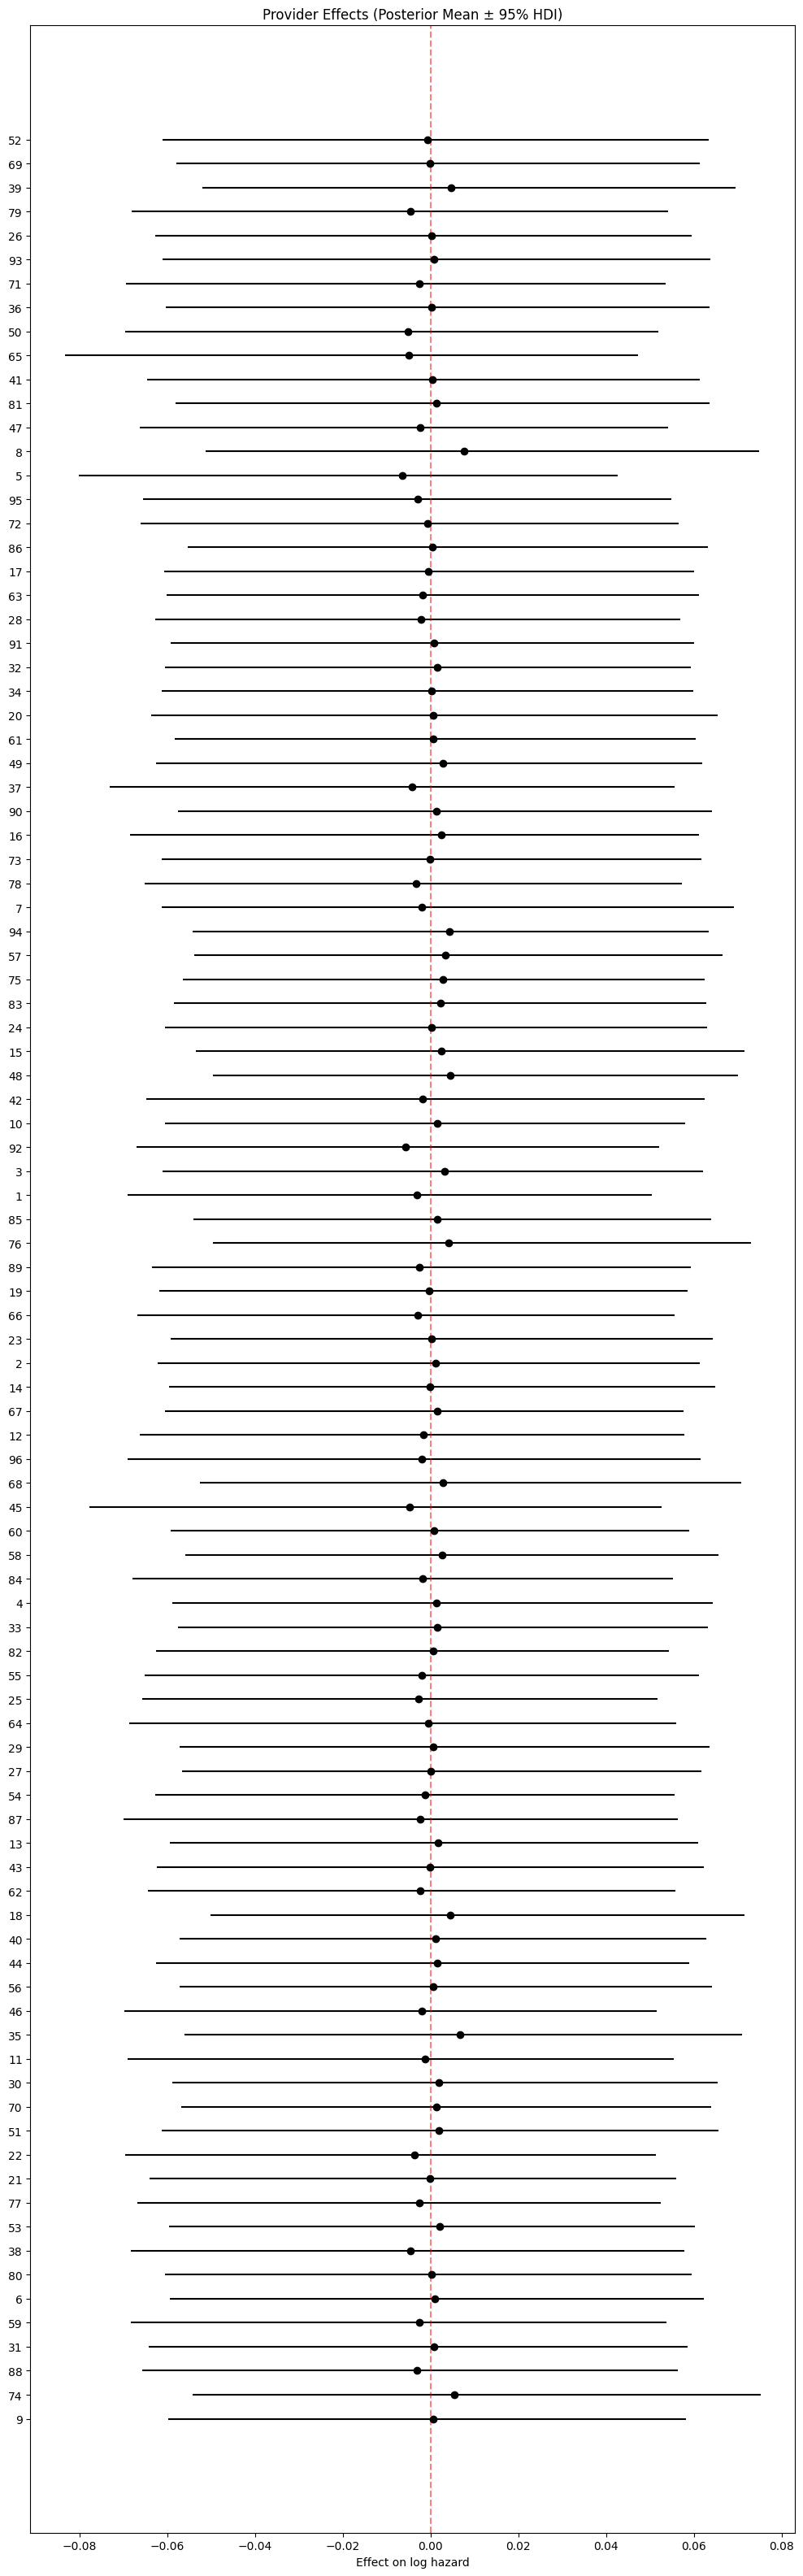

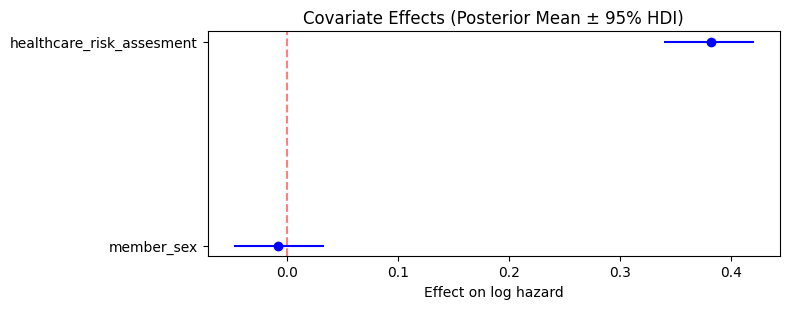

In [21]:
plot_bayesian_cox_effects(coxdata, provider_names, ["member_sex", "healthcare_risk_assesment"], hdi_prob=0.95)

#### Results and Interpretation : 
- Simulating follow up time and event times we can see how we could assess the provider effect with regard to time to event which would allow us to answer the question do providers have an effect of the time to failure or event